In [1]:
WA = ['washington', 'wa', 'aberdeen', 'anacortes', 'auburn', 'bellevue', 
      'bellingham', 'bremerton', 'centralia', 'coulee dam', 'coupeville',
      'ellensburg', 'ephrata', 'everett', 'hoquiam', 'kelso',
      'kennewick', 'longview', 'moses lake', 'oak harbor', 'olympia', 
      'pasco', 'point roberts', 'port angeles', 'pullman', 'puyallup',
      'redmond', 'renton', 'richland', 'seattle', 'spokane', 'tacoma',
      'walla walla', 'wenatchee', 'yakima']

MA = ['massachusetts', 'ma', 'abington', 'adams', 'amesbury', 'amherst',
      'andover', 'arlington', 'athol', 'attleboro', 'barnstable',
      'bedford', 'beverly', 'boston', 'bourne', 'braintree',
      'brockton', 'brookline', 'cambridge', 'canton', 'charlestown',
      'chelmsford', 'chelsea', 'chicopee', 'clinton', 'cohasset',
      'concord', 'danvers', 'dartmouth', 'dedham', 'dennis',
      'duxbury', 'eastham', 'edgartown', 'everett', 'fairhaven',
      'fall river', 'falmouth', 'fitchburg', 'framingham', 'gloucester',
      'great barrington', 'greenfield', 'groton', 'harwich', 'haverhill',
      'hingham', 'holyoke', 'hyannis', 'ipswich', 'lawrence',
      'lenox', 'leominster', 'lexington', 'lowell', 'ludlow',
      'lynn', 'malden', 'marblehead', 'marlborough', 'medford',
      'milton', 'nahant', 'natick', 'new bedford', 'newburyport',
      'newton', 'north adams', 'northampton', 'norton', 'norwood',
      'peabody', 'pittsfield', 'plymouth', 'provincetown', 'quincy',
      'randolph', 'revere', 'salem', 'sandwich', 'saugus',
      'somerville', 'south hadley', 'springfield', 'stockbridge', 'stoughton',
      'sturbridge', 'sudbury', 'taunton', 'tewksbury', 'truro',
      'watertown', 'webster', 'wellesley', 'wellfleet', 'west bridgewater',
      'west springfield', 'westfield', 'weymouth', 'whitman', 'williamstown', 
      'woburn', 'woods hole', 'worcester']

In [2]:
def in_wa(location):
    flag = False
    black_list = ["dc", "d.c.", "d.c."]
    location = location.split()
    
    for s in WA:
        if s in location:
            flag = True
            break

    for s in black_list:
        if s in location:
            flag = False
            break
    return flag

def in_ma(location):
    flag = False
    black_list = ["ohio"]
    location = location.split()
    
    for s in MA:
        if s in location:
            flag = True
            break

    for s in black_list:
        if s in location:
            flag = False
            break
    return flag

***Read data***

In [3]:
import json

input_file = open('./tweet_data/tweets_#superbowl.txt')

titles = []
locations = []
labels = []

for line in input_file:
    data = json.loads(line)
    location = data.get("tweet").get("user").get("location").lower()
    locations.append(location)
    
    if in_wa(location):
        labels.append(0)
        titles.append(data['title'])
    elif in_ma(location):
        labels.append(1)
        titles.append(data['title'])
        
input_file.close()

***Split train data and test data***

In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(titles, labels, test_size=0.1, random_state=42)

In [5]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import text
from nltk.stem.snowball import SnowballStemmer
import string,re

def stemming_tokenizer(text):
    stemmer = SnowballStemmer("english")
    text = "".join([a for a in text if a not in string.punctuation]) # remove all punctuation
    text = re.sub('[,.-:/()?{}*$#&]',' ', text) # remove all symbols
    text = "".join(b for b in text if ord(b) < 128) # remove all non-ascii characters
    words = text.split()
    stemmed = [stemmer.stem(item) for item in words]
    return stemmed

stop_words = text.ENGLISH_STOP_WORDS

count_vectorizer = CountVectorizer(analyzer='word' , tokenizer=stemming_tokenizer, stop_words=stop_words, min_df=4, max_df =0.99)
X_train_counts = count_vectorizer.fit_transform(X_train)
X_test_counts = count_vectorizer.transform(X_test)

***TFxIDF***

In [6]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_test_tfidf = tfidf_transformer.transform(X_test_counts)

In [7]:
from sklearn.decomposition import TruncatedSVD

SVD = TruncatedSVD(n_components=50, random_state=42)
transformed_train_tfidf = SVD.fit_transform(X_train_tfidf)
transformed_test_tfidf = SVD.transform(X_test_tfidf)

In [10]:
transformed_train_tfidf.shape

(39108, 50)

In [25]:
transformed_test_tfidf.shape

(4346, 50)

***Classifier***

In [22]:
from sklearn.metrics import roc_curve, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import numpy as np

def print_statistics(labels, predicted, classifier_name):
    print("Accuracy of "+ str(classifier_name)+ "Classifier: " + str(np.mean(predicted == labels)))
    print("Classification report: ")
    print(classification_report(labels, predicted, target_names=['Washington', 'Massachusetts']))
    print("Confusion Matrix: ")
    print(confusion_matrix(labels, predicted))

def plot_roc(labels, predicted, classifier_name):
    fpr, tpr, threshold = roc_curve(labels, predicted)
    line = [0, 1]
    plt.figure(figsize=(10,10))
    plt.plot(fpr, tpr)
    plt.plot([0,1],[0,1])
    plt.ylabel('True Positive Rate', fontsize = 20)
    plt.xlabel('False Positive Rate', fontsize = 20)
    plt.title('ROC Curves for ' + str(classifier_name) + 'Classifier', fontsize = 20)
    plt.axis([-0.004, 1, 0, 1.006])
    plt.show()

def classify(X_train, y_train, X_test, y_test, classifier, classifier_name):
    classifier.fit(X_train, y_train)
    predicted = classifier.predict(X_test)
    predicted_probs = classifier.predict_proba(X_test)
    print_statistics(y_test, predicted, classifier_name)
    plot_roc(y_test, predicted_probs[:, 1], classifier_name) 

Statistics of Multinomial naïve Bayes Classifier:
Accuracy ofMultinomial naïve BayesClassifier: 0.549930971008
Classification report: 
               precision    recall  f1-score   support

   Washington       0.85      0.01      0.01      1965
Massachusetts       0.55      1.00      0.71      2381

  avg / total       0.68      0.55      0.39      4346

Confusion Matrix: 
[[  11 1954]
 [   2 2379]]


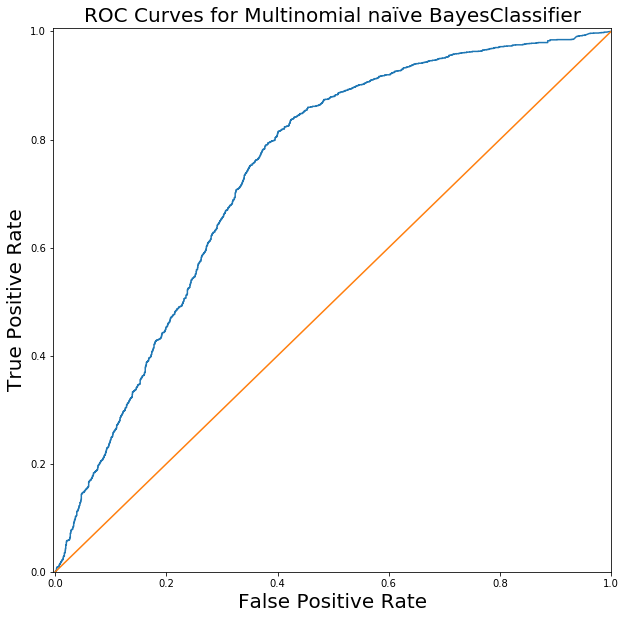

Statistics of LogisticRegression with L1 norm regularizations:
Accuracy ofLogisticRegression with L1 norm regularizationsClassifier: 0.790151863783
Classification report: 
               precision    recall  f1-score   support

   Washington       0.92      0.59      0.72      1965
Massachusetts       0.74      0.96      0.83      2381

  avg / total       0.82      0.79      0.78      4346

Confusion Matrix: 
[[1151  814]
 [  98 2283]]


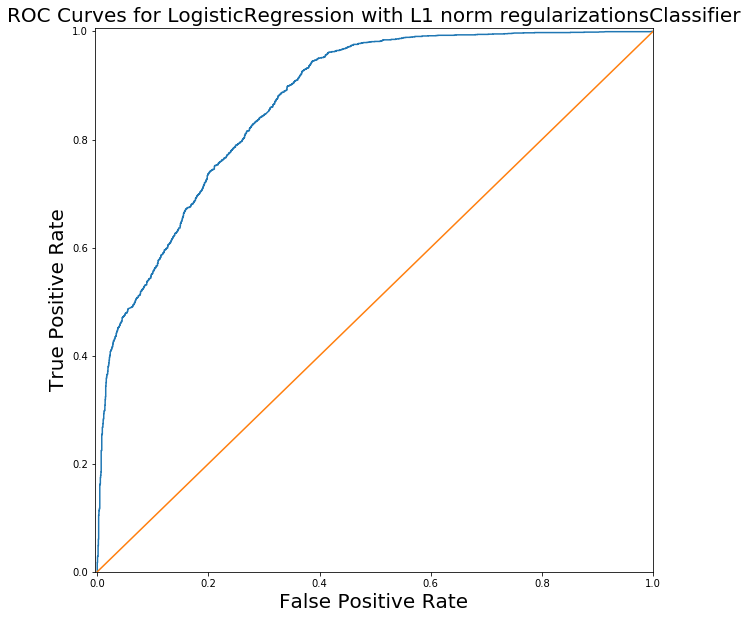

Statistics of LogisticRegression with L2 norm regularizations:
Accuracy ofLogisticRegression with L2 norm regularizationsClassifier: 0.790381960423
Classification report: 
               precision    recall  f1-score   support

   Washington       0.92      0.59      0.72      1965
Massachusetts       0.74      0.96      0.83      2381

  avg / total       0.82      0.79      0.78      4346

Confusion Matrix: 
[[1151  814]
 [  97 2284]]


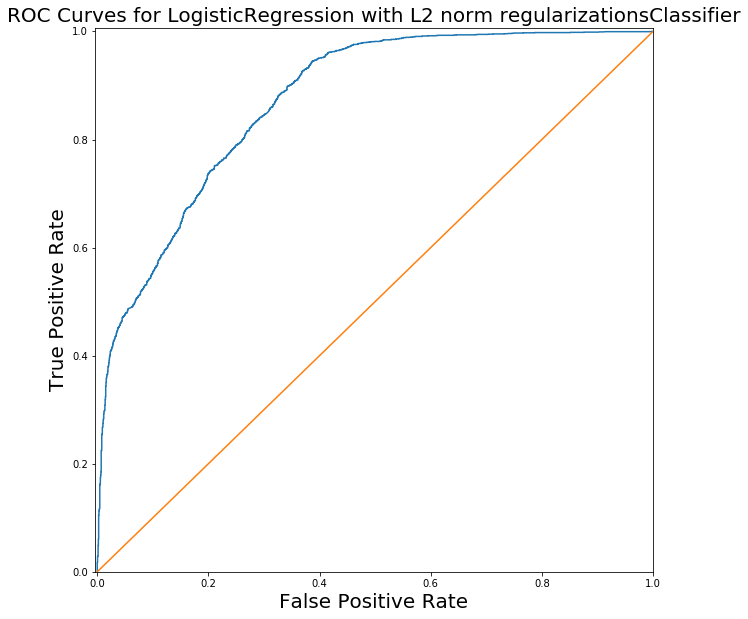

Statistics of AdaBoost Classifier:
Accuracy ofAdaBoostClassifier: 0.787850897377
Classification report: 
               precision    recall  f1-score   support

   Washington       0.89      0.60      0.72      1965
Massachusetts       0.74      0.94      0.83      2381

  avg / total       0.81      0.79      0.78      4346

Confusion Matrix: 
[[1184  781]
 [ 141 2240]]


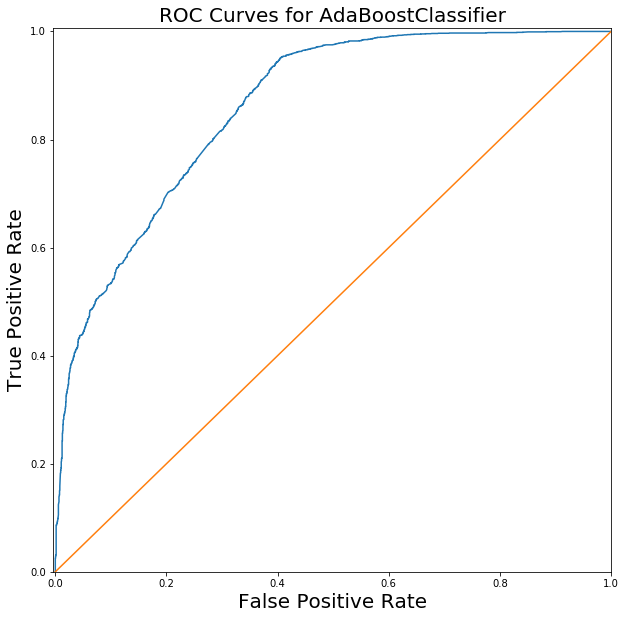

Statistics of Random Forest Classifier:
Accuracy ofRandomForestClassifierClassifier: 0.668660837552
Classification report: 
               precision    recall  f1-score   support

   Washington       0.87      0.31      0.46      1965
Massachusetts       0.63      0.96      0.76      2381

  avg / total       0.74      0.67      0.63      4346

Confusion Matrix: 
[[ 616 1349]
 [  91 2290]]


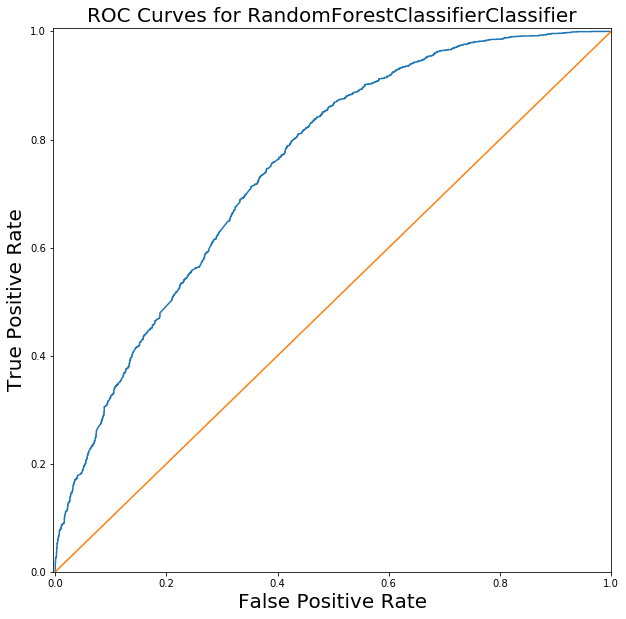

Statistics of SVM Classifier:
Accuracy ofSVMClassifier: 0.779567418316
Classification report: 
               precision    recall  f1-score   support

   Washington       0.92      0.56      0.70      1965
Massachusetts       0.73      0.96      0.83      2381

  avg / total       0.81      0.78      0.77      4346

Confusion Matrix: 
[[1106  859]
 [  99 2282]]


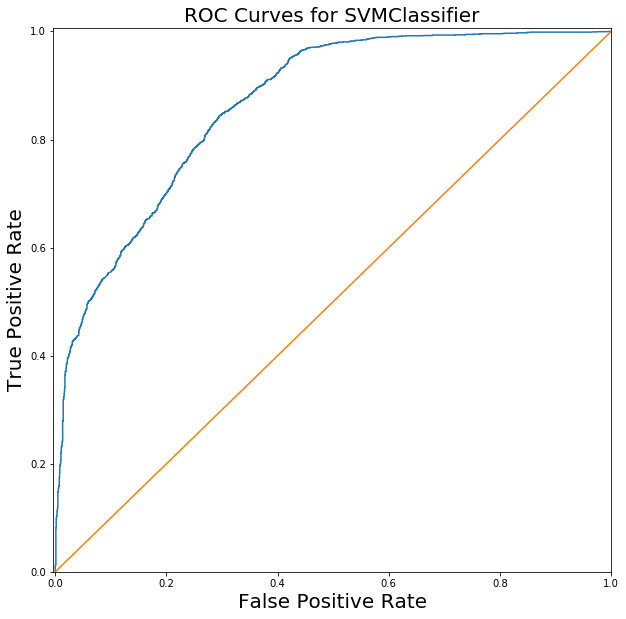

In [26]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn import svm
from sklearn.preprocessing import MinMaxScaler

min_max_scaler = MinMaxScaler()
scaled_tfidf= min_max_scaler.fit_transform(transformed_train_tfidf)
scaled_test_tfidf = min_max_scaler.fit_transform(transformed_test_tfidf)

print("Statistics of Multinomial naïve Bayes Classifier:")
classify(scaled_tfidf, y_train, scaled_test_tfidf, y_test, MultinomialNB(), "Multinomial naïve Bayes")

print("Statistics of LogisticRegression with L1 norm regularizations:")
classify(transformed_train_tfidf, y_train, transformed_test_tfidf, y_test, LogisticRegression(C = 1000 , penalty = 'l1'), "LogisticRegression with L1 norm regularizations")

print("Statistics of LogisticRegression with L2 norm regularizations:")
classify(transformed_train_tfidf, y_train, transformed_test_tfidf, y_test, LogisticRegression(C = 1000 , penalty = 'l2'), "LogisticRegression with L2 norm regularizations")

print("Statistics of AdaBoost Classifier:")
classify(transformed_train_tfidf, y_train, transformed_test_tfidf, y_test, AdaBoostClassifier(), "AdaBoost")

print("Statistics of Random Forest Classifier:")
classify(transformed_train_tfidf, y_train, transformed_test_tfidf, y_test, RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1), "RandomForestClassifier")

print("Statistics of SVM Classifier:")
classify(transformed_train_tfidf, y_train, transformed_test_tfidf, y_test, svm.SVC(kernel='linear', probability=True), "SVM")